## Машинное обучение

## Домашнее задание 3


### О задании

Ниже даны несколько заданий. Первые два из них самодостаточные, они позволяют лучше познакомиться с логистической регрессией и ROC-кривой. Далее 3 задания выполняются на реальном наборе данных: вам предлагается настроить логистическую регрессию на них, измерить различные метрики качества, попробовать закодировать категориальные признаки и посмотреть на изменение качества предсказаний. Также в последнем задании предлагается самостоятельно разобраться с методами калибровки вероятностей. 

В каждом задании указано число баллов. Почти все задание основано на использовании готовых методов из sklearn и анализе результатов их работы.

In [21]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


### Задание 1. Обучение логистической регресии на синтетических данных. (2 балла)

Сгенерируйте синтетический датасет для бинарной классификации с помощью `make_classification` с 2 признаками, обучите на нём логистическую регресию. Визуализируйте разделяющую прямую и все объекты. Из иллюстрации должно быть понятно, к какому классу принадлежит объект, и к какому классу его отнесла регресия (это удобно демонстрировать заливкой цветом). 

In [2]:
dataset= make_classification(n_features=2, n_redundant=0)
X=dataset[0]
y=dataset[1]
log=LogisticRegression()
log.fit(X,y)

C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Взял код графика отсюда https://habr.com/ru/company/ods/blog/323890/

In [0]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'yellow'])

def plot_boundary(clf, X, y, plot_title='Log Regression'):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 50),
    np.linspace(X[:,1].min(), X[:,1].max(), 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)
    image = plt.imshow(Z, interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect='auto', origin='lower', cmap=colors)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
    linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xlabel(r'X1')
    plt.ylabel(r'X2')
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12)
    plt.show();

C:\ProgramData\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\ProgramData\Anaconda\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


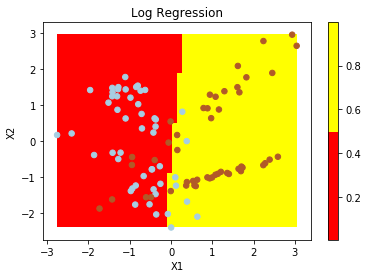

In [0]:
plot_boundary(log, X,y)

### Задание 2. Самостоятельная реализация вычисления AUC ROC. (3 балла)

Напишите функцию, которая берет на вход `numpy`-вектор правильных ответов `y` (из 0 и 1) и `numpy`-вектор вещественных предсказаний классификатора (длина обоих векторов равна числу объектов) и возвращает значение AUC ROC. Как обычно, можно пользоваться только средствами `numpy` :) Считайте, что в векторе `score_predicted` все элементы различны.

In [118]:
def roc_auc(y_true, score_predicted):#score_predicted - вектор вероятности принадлежать классу 1,т.е. log.predict_proba(X)[:,1]
    recall=[]
    FPR=[]
    
    matrix=np.hstack([y_true.reshape(-1,1),score_predicted.reshape(-1,1)])
    ind=np.argsort(matrix[:,1], axis=0)
    sort= matrix[ind.ravel(),:] 
    
    pudge3228=np.zeros(y_true.shape)
    for i in sort[:,1]:
        otsechenie= i
        np.place(pudge3228, score_predicted<otsechenie, 0)
        np.place(pudge3228, score_predicted>=otsechenie, 1)
        Ugadaly1=pudge3228.dot(y_true)
        FPR.append((pudge3228.sum()-Ugadaly1)/(y_true.shape[0]-y_true.sum()))
        recall.append(Ugadaly1/y_true.sum())
    return np.trapz(recall, x=FPR)*(-1)

Напишите юнит-тесты (не менее 3) к вашей реализации. Тест — это функция, которая подает на вход `roc_auc` некоторые заранее определенные векторы и проверяет корректность ответа (для заданных векторов вы знаете, какой должен быть ответ). Например, для вызова `roc_auc([0, 1], [0.2, 0.7])` функция должна вернуть 1. Тесты должны проверять разные сценарии работы функции (например, не нужно писать несколько тестов, которые проверяют что в случае идеального классификатора roc-auc равен 1). В юнит-тестах удобно использовать [assert](https://stackoverflow.com/questions/5142418/what-is-the-use-of-assert-in-python)-ы.

In [129]:
import random

def test3():
    random.seed(96)
    y_true=[]
    score_predicted=[]
    for i in range(random.randint(5,100)):
        y_true.append(random.randint(0,1))
        score_predicted.append(random.random())
    assert roc_auc(np.array(y_true),np.array(score_predicted) )== metrics.roc_auc_score(np.array(y_true),np.array(score_predicted))
    
def test4():
    random.seed(156)
    y_true=[]
    score_predicted=[]
    for i in range(random.randint(5,100)):
        y_true.append(random.randint(0,1))
        score_predicted.append(random.random())
    assert roc_auc(np.array(y_true),np.array(score_predicted) )== metrics.roc_auc_score(np.array(y_true),np.array(score_predicted)) 
    
def test5():
    random.seed(13)
    y_true=[]
    score_predicted=[]
    for i in range(random.randint(5,100)):
        y_true.append(random.randint(0,1))
        score_predicted.append(random.random())
    assert roc_auc(np.array(y_true),np.array(score_predicted) )== metrics.roc_auc_score(np.array(y_true),np.array(score_predicted)) 

In [130]:
test3()

In [131]:
test4()

In [132]:
test5()

### Задание 3. Обучение логистической регрессии на реальных данных и оценка качества классификации (4 балла)

Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

**На моем компьютере не хватало памяти для задания 4, поэтому пришлось делать через колаб, поэтому файл с данными расположен так неудобно**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
data = pd.read_csv('/content/drive/My Drive/data/train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)


Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [0]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Отнормируйте признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [0]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [21]:
%%time
log=LogisticRegression()
log.fit(X_train,y_train)
log.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 10.9 s, sys: 28.7 ms, total: 11 s
Wall time: 11 s


Постройку ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

Код для ROC взят отсюда https://geekquestion.com/10908405-kak-postroit-krivuju-roc-v-python/

Код для PR curve взят с документации https://scikit-learn.org/0.21/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

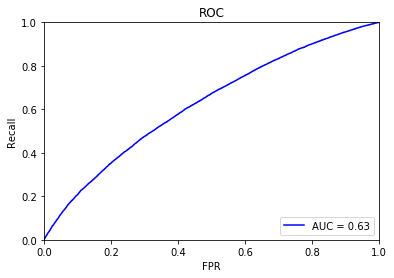

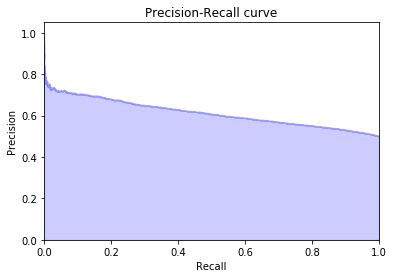

In [0]:
#ROC
from sklearn import metrics

probs = log.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Recall')
plt.xlabel('FPR')
plt.show();

#Precison-Recall
from inspect import signature

precision, recall, _ = metrics.precision_recall_curve(y_test, preds)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show();

In [0]:
print('ROC-AUC:', roc_auc)
print('PR-AUC:', metrics.average_precision_score(y_test, preds))

ROC-AUC: 0.6250596178008585
PR-AUC: 0.6128804401176504


Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [7]:
print('Так как recall равен 0.7, то количество правильно предсказанных объектов первого класса должно быть равно',y_test.sum()*0.7)

Так как recall равен 0.7, то количество правильно предсказанных объектов первого класса должно быть равно 35004.2


In [0]:
pudge3228=np.zeros(preds.shape)
for i in range(10,-1,-1):
    otsechenie= i*0.1
    print('Порог=',otsechenie)
    np.place(pudge3228, preds<otsechenie, 0)
    np.place(pudge3228, preds>=otsechenie, 1)
    Ugadaly1=pudge3228.dot(y_test)
    print("Сумма верно отмеченных объектов 1 класса=",Ugadaly1)

Порог= 1.0
Сумма верно отмеченных объектов 1 класса= 0.0
Порог= 0.9
Сумма верно отмеченных объектов 1 класса= 35.0
Порог= 0.8
Сумма верно отмеченных объектов 1 класса= 794.0
Порог= 0.7000000000000001
Сумма верно отмеченных объектов 1 класса= 3497.0
Порог= 0.6000000000000001
Сумма верно отмеченных объектов 1 класса= 12001.0
Порог= 0.5
Сумма верно отмеченных объектов 1 класса= 27469.0
Порог= 0.4
Сумма верно отмеченных объектов 1 класса= 43713.0
Порог= 0.30000000000000004
Сумма верно отмеченных объектов 1 класса= 49628.0
Порог= 0.2
Сумма верно отмеченных объектов 1 класса= 50006.0
Порог= 0.1
Сумма верно отмеченных объектов 1 класса= 50006.0
Порог= 0.0
Сумма верно отмеченных объектов 1 класса= 50006.0


Видимо, порог отсечения между 0.4 и 0.5

In [0]:
pudge3228=np.zeros(preds.shape)
for i in range(50,40,-1):
    otsechenie= i*0.01
    print('Порог=',otsechenie)
    np.place(pudge3228, preds<otsechenie, 0)
    np.place(pudge3228, preds>=otsechenie, 1)
    Ugadaly1=pudge3228.dot(y_test)
    print("Сумма верно отмеченных объектов 1 класса=",Ugadaly1)

Порог= 0.5
Сумма верно отмеченных объектов 1 класса= 27469.0
Порог= 0.49
Сумма верно отмеченных объектов 1 класса= 29357.0
Порог= 0.48
Сумма верно отмеченных объектов 1 класса= 31045.0
Порог= 0.47000000000000003
Сумма верно отмеченных объектов 1 класса= 32778.0
Порог= 0.46
Сумма верно отмеченных объектов 1 класса= 34524.0
Порог= 0.45
Сумма верно отмеченных объектов 1 класса= 36178.0
Порог= 0.44
Сумма верно отмеченных объектов 1 класса= 37806.0
Порог= 0.43
Сумма верно отмеченных объектов 1 класса= 39527.0
Порог= 0.42
Сумма верно отмеченных объектов 1 класса= 41006.0
Порог= 0.41000000000000003
Сумма верно отмеченных объектов 1 класса= 42355.0


Видимо, порог отсечения равен 0.455
При recall>=0.7 значение precision примерно <= 0.6

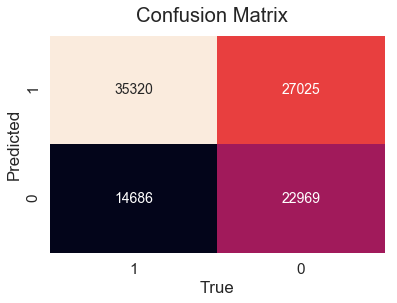

In [0]:
pudge3228=np.zeros(preds.shape)
np.place(pudge3228, preds<0.455, 0)
np.place(pudge3228, preds>=0.455, 1)
tn, fp, fn, tp=metrics.confusion_matrix(y_test,pudge3228).ravel()
conf_mat= np.array([[tp,fp],[fn,tn]])
import seaborn as sn
     
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14}, fmt='d',cbar=False,xticklabels=[1,0], yticklabels=[1,0])
plt.ylabel('Predicted')
plt.xlabel('True')
plt.suptitle('Confusion Matrix')
plt.show()

При значении полноты равном 0.7 мы жертвуем точностью. Такой алгоритм будет чаще ошибаться, чем другой с большей точностью и меньшей полнотой, но зато чаще находить объектов заданного класса. Например, алгоритм с такой полнотой будет нужен, когда мы определяем потенциально больных страшной болезнью. Так как нам ничего не стоит отправить их на медосмотр, но если мы не выявим у них болезнь, то они умрут. Поэтому цена ошибки не так важна, как цена "не нахождения".

### Задание 4. Кодирование категориальных признаков (1 балл)

Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество моделей. Измерьте время, потребовавшееся на обучение модели.

Реализация взята отсюда https://www.kaggle.com/danofer/xgb-onehot-encoding-lb-0-281

In [0]:
cat_values = [s for s in data.columns if "_cat" in s]
combine=data
for column in cat_values:
    temp=pd.get_dummies(pd.Series(combine[column]))
    combine=pd.concat([combine,temp],axis=1)
    combine=combine.drop([column],axis=1) 



In [0]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(combine, target, test_size=0.5)
scaler.fit(X_train2)
scaler.transform(X_train2)
scaler.transform(X_test2)

In [11]:
%%time
log.fit(X_train2,y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 15.8 s, sys: 27.9 ms, total: 15.9 s
Wall time: 15.9 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
from sklearn import metrics
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test2, log.predict_proba(X_test2)[:,1])

print('ROC-AUC:', metrics.auc(fpr2, tpr2))
print('PR-AUC:', metrics.average_precision_score(y_test2, log.predict_proba(X_test2)[:,1]))

ROC-AUC: 0.6329705976510118
PR-AUC: 0.6254819341376506


Времени потребовалось чуть больше, но и качество увеличилось

### Задание 5. Калибровка вероятностей (4 балла)

В этом задании предлагается самостоятельно разобраться с калибровкой вероятностей. Для этого можно прочитать первый раздел в [конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem06.pdf).

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [0]:
def plot_calibration_curve(y_test, preds): 
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    segment_width = 1.0 / n_bins
    for i in range(n_bins):
        left = segment_width * i
        right = segment_width * (i + 1)
        bin_middle_points.append((left + right) / 2) #Ошибка 1
        bin_real_ratios.append(
            np.mean(y_test[(preds >= left) & (preds < right)] == 1) #Ошибка 2
        )
    plt.plot(bin_middle_points, bin_real_ratios)

Постройте калибровочную кривую для логистической регрессии (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификатора (постройте гистограмму с помощью `plt.hist`).

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


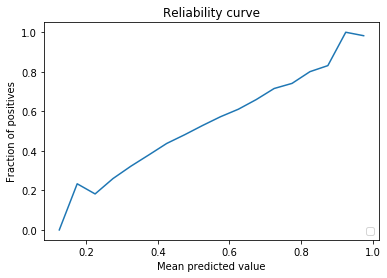

In [16]:
plot_calibration_curve(y_test2, log.predict_proba(X_test2)[:,1])
plt.title('Reliability curve')
plt.legend(loc = 'lower right')
plt.ylabel("Fraction of positives")
plt.xlabel('Mean predicted value')
plt.show();

No handles with labels found to put in legend.


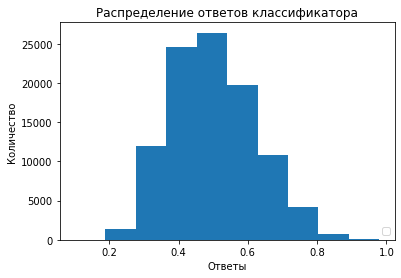

In [17]:
plt.hist(log.predict_proba(X_test2)[:,1])
plt.title('Распределение ответов классификатора')
plt.legend(loc = 'lower right')
plt.ylabel("Количество")
plt.xlabel('Ответы')
plt.show();

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей логистической регресии на обучении и постройте с его помощью предсказание для тестовой выборки. Нарисуйте на одном графике калибровочную кривую до и после калибровки. Есть ли улучшения?

In [0]:
from sklearn.calibration import CalibratedClassifierCV
calibr= CalibratedClassifierCV(base_estimator=log)
calibr.fit(X_train2,y_train2);

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


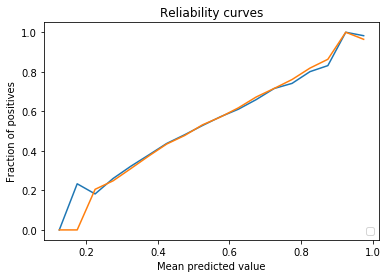

In [19]:
plot_calibration_curve(y_test2, log.predict_proba(X_test2)[:,1])
plt.title('Reliability curves')
plt.legend(loc = 'lower right')
plt.ylabel("Fraction of positives")
plt.xlabel('Mean predicted value')

plot_calibration_curve(y_test2, calibr.predict_proba(X_test2)[:,1])
plt.show();

Есть улучшение на отрезке [0;0.23], а дальше, в принципе, нет

Что будет, если усилить регуляризацию логистической регресии в $10^3$ раз? Нарисуйте на одном графике калибровочную кривую для сильно регуляризованной регресии и для неё же после калибровки. Есть ли улучшения?

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lo

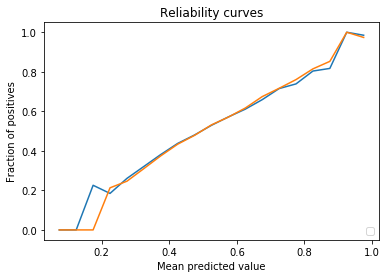

CPU times: user 1min 54s, sys: 1.11 s, total: 1min 55s
Wall time: 1min 54s


In [20]:
%%time
log1000= LogisticRegression(C=1000)
log1000.fit(X_train2, y_train2)

plot_calibration_curve(y_test2, log1000.predict_proba(X_test2)[:,1])
plt.title('Reliability curves')
plt.legend(loc = 'lower right')
plt.ylabel("Fraction of positives")
plt.xlabel('Mean predicted value')

calibr1000= CalibratedClassifierCV(base_estimator=log1000)
calibr1000.fit(X_train2,y_train2)

plot_calibration_curve(y_test2, calibr1000.predict_proba(X_test2)[:,1])
plt.show();

По-моему, они что до этого, что сейчас одинаковые. Никаких особых изменений. Стало чуть лучше, но не сильно.
